http://billchambers.me/tutorials/2015/01/14/python-nlp-cheatsheet-nltk-scikit-learn.html

http://glowingpython.blogspot.de/2013/07/combining-scikit-learn-and-ntlk.html

http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html

https://stackoverflow.com/questions/10526579/use-scikit-learn-to-classify-into-multiple-categories

https://github.com/anuraagvak/IRE-PersonalityRecognition-Final/blob/master/ire_report.pdf

https://github.com/Charudatt89/Personality_Recognition/blob/master/22-9-PersonalityRecognition/Report/Report.pdf

http://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python

In [79]:
import pandas as pd
import numpy as np
import re, reprlib, sys
import matplotlib.pyplot as plt
from itertools import *

%load_ext cython
%load_ext cythonmagic
%matplotlib inline

from pandas_confusion import ConfusionMatrix

import nltk as n
import nltk, nltk.classify.util, nltk.metrics, nltk.tokenize, nltk.stem
from nltk.corpus import *
from nltk.stem import *
from nltk.classify import *
from nltk.collocations import *
from nltk.metrics import BigramAssocMeasures as BAM
from nltk.probability import *
from nltk.classify.scikitlearn import *
from nltk.tag.sequential import *
from nltk.tag import *
from nltk.tag.util import *


import sklearn as sk
from sklearn import *
from sklearn.feature_extraction.text import *
from sklearn.svm import *
from sklearn.pipeline import *
from sklearn.multiclass import *
from sklearn.naive_bayes import *
from sklearn.neighbors import *
from sklearn.feature_selection import *
from sklearn.ensemble import *

# n.download()

The cython extension is already loaded. To reload it, use:
  %reload_ext cython
The cythonmagic extension is already loaded. To reload it, use:
  %reload_ext cythonmagic


### Read data and show them

In [32]:
data = pd.read_csv("data.csv", parse_dates=True, infer_datetime_format=True, 
            sep = None, encoding = "latin-1", engine = "python")
data.head(n=2)
# data.describe()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,NETWORKSIZE,BETWEENNESS,NBETWEENNESS,DENSITY,BROKERAGE,NBROKERAGE,TRANSITIVITY
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,180,14861.6,93.29,0.03,15661,0.49,0.1
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she ca...,2.65,3,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,180,14861.6,93.29,0.03,15661,0.49,0.1


In [3]:
d = {'n': "no", 'y': "yes"}

# http://stackoverflow.com/a/17702781
data = data.replace(d)

neu = data[["#AUTHID","STATUS","cNEU"]]
ext = data[["#AUTHID","STATUS","cEXT"]]
agr = data[["#AUTHID","STATUS","cAGR"]]
con = data[["#AUTHID","STATUS","cCON"]]
opn = data[["#AUTHID","STATUS","cOPN"]]

In [5]:
# plit data
train_neu, test_neu = sk.cross_validation.train_test_split(neu, train_size = 0.66)
train_ext, test_ext = sk.cross_validation.train_test_split(ext, train_size = 0.66)
train_agr, test_agr = sk.cross_validation.train_test_split(agr, train_size = 0.66)
train_con, test_con = sk.cross_validation.train_test_split(con, train_size = 0.66)
train_opn, test_opn = sk.cross_validation.train_test_split(opn, train_size = 0.66)
print(len(train_neu))

6545


### Creates diff. pipelines here!

with stop_words : ‘english’ in CountVecto or T.Vecto accuracy ussualy lower

In [76]:
target_names = ['yes', 'no']

# Support Vector Machines
classifierLinearSVC = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())]) # OneVsRestClassifier already implemented, docs: http://scikit-learn.org/stable/modules/svm.html#multi-class-classification

classifierSVC = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer()),
    ('clf', SVC(cache_size=500))]) # "one-against-one", docs: http://scikit-learn.org/stable/modules/svm.html#multi-class-classification

# Two Naybe Bayes below are also same
classifierOVR_NB = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(MultinomialNB()))]) # OneVsOneClassifier does not play role

classifierNB = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('nb', MultinomialNB())])

classifierBNB = Pipeline([    
    ('vectorizer_tfidf', TfidfVectorizer()),
    ('bnb', BernoulliNB())])

# Nearest Neighboars
classifier_kNN = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer()),
    ('kNN', KNeighborsClassifier())]) # http://scikit-learn.org/stable/modules/neighbors.html#neighbors

# Random Forest
classifierRF = Pipeline([    
    ('vectorizer_tfidf', TfidfVectorizer()),
    ('rfc', RandomForestClassifier(n_jobs=-1))])

classifierADC = Pipeline([    
    ('vectorizer_tfidf', TfidfVectorizer()),
    ('adc', AdaBoostClassifier())])


### cNEU

In [78]:
clas_fit = classifierSVC.fit(train_neu["STATUS"], train_neu["cNEU"])
predicted = classifierSVC.predict(test_neu["cNEU"])
scores = cross_validation.cross_val_score(classifierSVC, neu["STATUS"], neu["cNEU"], cv = 5)
print("Accuracy rbf kernel SVC: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

clas_fit = classifierLinearSVC.fit(train_neu["STATUS"], train_neu["cNEU"])
predicted = classifierLinearSVC.predict(test_neu["cNEU"])
scores = cross_validation.cross_val_score(classifierLinearSVC, neu["STATUS"], neu["cNEU"], cv = 5)
print("Accuracy LinearSVC: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print("\n")

clas_fit = classifierBNB.fit(train_neu["STATUS"], train_neu["cNEU"])
predicted = classifierBNB.predict(test_neu["cNEU"])
scores = cross_validation.cross_val_score(classifierBNB, neu["STATUS"], neu["cNEU"], cv = 5)
print("Accuracy of bernuli NB: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

clas_fit = classifierNB.fit(train_neu["STATUS"], train_neu["cNEU"])
predicted = classifierNB.predict(test_neu["cNEU"])
scores = cross_validation.cross_val_score(classifierNB, neu["STATUS"], neu["cNEU"], cv = 5)
print("Accuracy NB: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

clas_fit = classifierOVR_NB.fit(train_neu["STATUS"], train_neu["cNEU"])
predicted = classifierOVR_NB.predict(test_neu["cNEU"])
scores = cross_validation.cross_val_score(classifierOVR_NB, neu["STATUS"], neu["cNEU"], cv = 5)
print("Accuracy of one-vs-rest NB: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


count = 0
for item, labels in zip(test_neu["STATUS"], predicted):
    count += 1
# print(count) # just for checking the count above +- 6000 and here 3372

Accuracy rbf kernel SVC: 0.625 (+/- 0.00)
Accuracy LinearSVC: 0.555 (+/- 0.01)


Accuracy of bernuli NB: 0.610 (+/- 0.01)
Accuracy NB: 0.624 (+/- 0.01)
Accuracy of one-vs-rest NB: 0.624 (+/- 0.01)


In [81]:
clas_fit_kNN = classifier_kNN.fit(train_neu["STATUS"], train_neu["cNEU"])
predicted_kNN = classifier_kNN.predict(test_neu["cNEU"])
scores_kNN = cross_validation.cross_val_score(classifier_kNN, neu["STATUS"], neu["cNEU"], cv = 5)
print("Accuracy of kNN: %0.3f (+/- %0.2f)" % (scores_kNN.mean(), scores_kNN.std() * 2))

print("")

clas_fit_ADC = classifierADC.fit(train_neu["STATUS"], train_neu["cNEU"])
predicted_ADC = classifierADC.predict(test_neu["cNEU"])
scores_ADC = cross_validation.cross_val_score(classifierADC, neu["STATUS"], neu["cNEU"], cv = 5)
print("Accuracy of AdaBoost: %0.3f (+/- %0.2f)" % (scores_ADC.mean(), scores_ADC.std() * 2))

clas_fit_RF = classifierRF.fit(train_neu["STATUS"], train_neu["cNEU"])
predicted_RF = classifierRF.predict(test_neu["cNEU"])
scores_RF = cross_validation.cross_val_score(classifierRF, neu["STATUS"], neu["cNEU"], cv = 5)
print("Accuracy of random Forest: %0.3f (+/- %0.2f)" % (scores_RF.mean(), scores_RF.std() * 2))

Accuracy of kNN: 0.421 (+/- 0.04)


Accuracy of AdaBoost: 0.604 (+/- 0.01)
Accuracy of random Forest: 0.594 (+/- 0.04)


### VotingClassifier

http://scikit-learn.org/stable/modules/ensemble.html#votingclassifier

In [ ]:
eclf = VotingClassifier(estimators=[
        ('lr', clas_fit), 
        ('rf', clf2), 
        ('gnb', clf3)], voting='hard')


for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_validation.cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

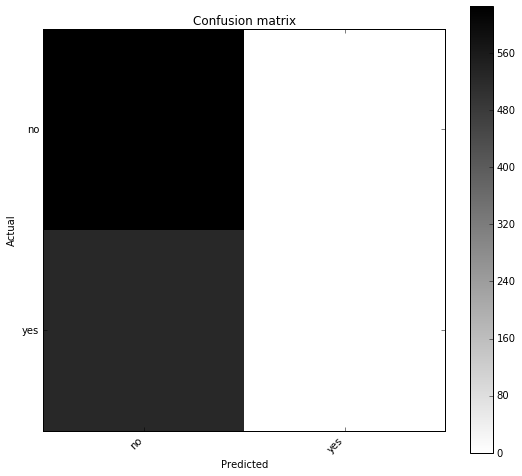

In [28]:
confusion_matrix = ConfusionMatrix(test_neu["cNEU"], predicted)
confusion_matrix.print_stats()
confusion_matrix.plot(normalized=False)

Bigram/Trigram training/test

In [29]:
tritagger = TrigramTagger(train_sents)